In [2]:
# Import libraries

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [3]:
# Load data

os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

eaton = gpd.read_file(os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp'))

palisades = gpd.read_file(os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp'))

eji_data = gpd.read_file(os.path.join('data','EJI_2024_California','EJI_2024_California.gdb'))

## 1. Metadata and CRS Exploration

In [4]:
eji_data.crs 

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
palisades.crs

<Projected CRS: PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GE ...>
Name: WGS_1984_Web_Mercator_Auxiliary_Sphere
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Check if eji_data and eaton are on same CRS
# assert(eaton.crs == eji_data.crs)

### Set eji_data `crs` to palisades `crs`

In [7]:
eji_data = eji_data.to_crs(palisades.crs)

In [8]:
assert(eaton.crs == eji_data.crs)

## 3. Polygon clipping and 2. Polygon intersection


### Palisades:

In [9]:
eji_palisades = gpd.sjoin(eji_data, palisades, predicate = 'intersects')

<Axes: >

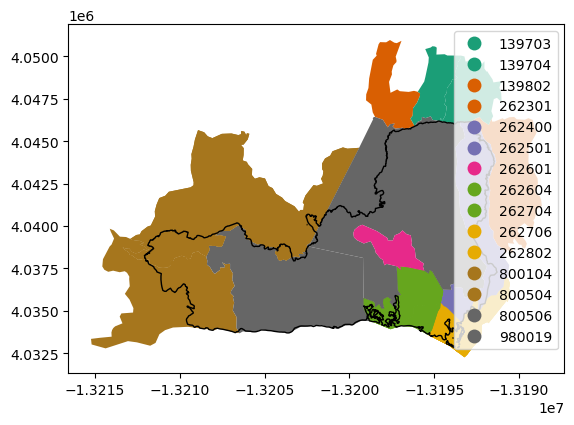

In [10]:
fig, ax = plt.subplots()


eji_palisades.plot(ax = ax, 
                column = 'TRACTCE',
                cmap = 'Dark2',
                legend = True
                 )

palisades.plot(ax = ax,
              color = 'none')

### Eaton:

In [11]:
eji_eaton = gpd.sjoin(eji_data, eaton, predicate = 'intersects')

<Axes: >

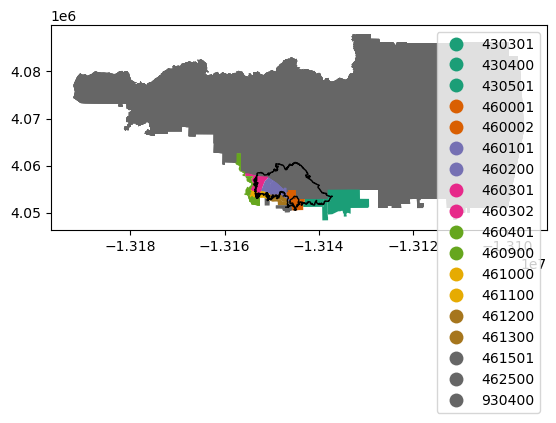

In [12]:
fig, ax = plt.subplots()

eji_eaton.plot(ax = ax, 
                column = 'TRACTCE',
                cmap = 'Dark2',
                legend = True
                 )

eaton.plot(ax = ax,
              color = 'none')

## 3. Polygon clipping

### Create palisades clip and visualize 

In [13]:
palisades_clip = gpd.clip(eji_palisades.to_crs(palisades.crs), palisades)

<Axes: >

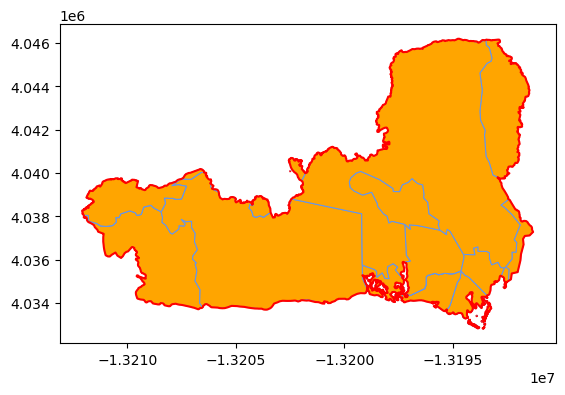

In [14]:
fig, ax = plt.subplots()

# Census Tracts
palisades_clip.plot(ax = ax, 
                #column = 'TRACTCE',
                edgecolor = 'cornflowerblue',
                color = 'orange',
                linewidth = 0.75,
                legend = True
                 )
# Fire Perimeter
palisades.plot(ax = ax,
              color = 'none',
               edgecolor = 'red',
               linewidth = 1.5
              )

### Create eaton clip and visualize 

In [15]:
eaton_clip = gpd.clip(eji_eaton.to_crs(eaton.crs), eaton)

<Axes: >

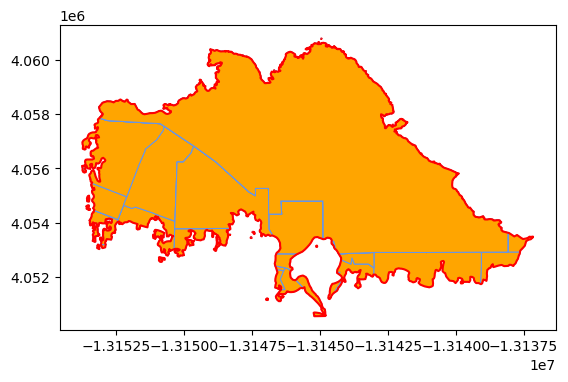

In [16]:
fig, ax = plt.subplots()


# Census Tracts
eaton_clip.plot(ax = ax, 
                #column = 'TRACTCE',
                edgecolor = 'cornflowerblue',
                color = 'orange',
                linewidth = 0.75,
                legend = True
                 )
# Fire Perimeter
eaton.plot(ax = ax,
              color = 'none',
               edgecolor = 'red',
               linewidth = 1.5
              )

## 4. Visualize fire perimeters with a basemap

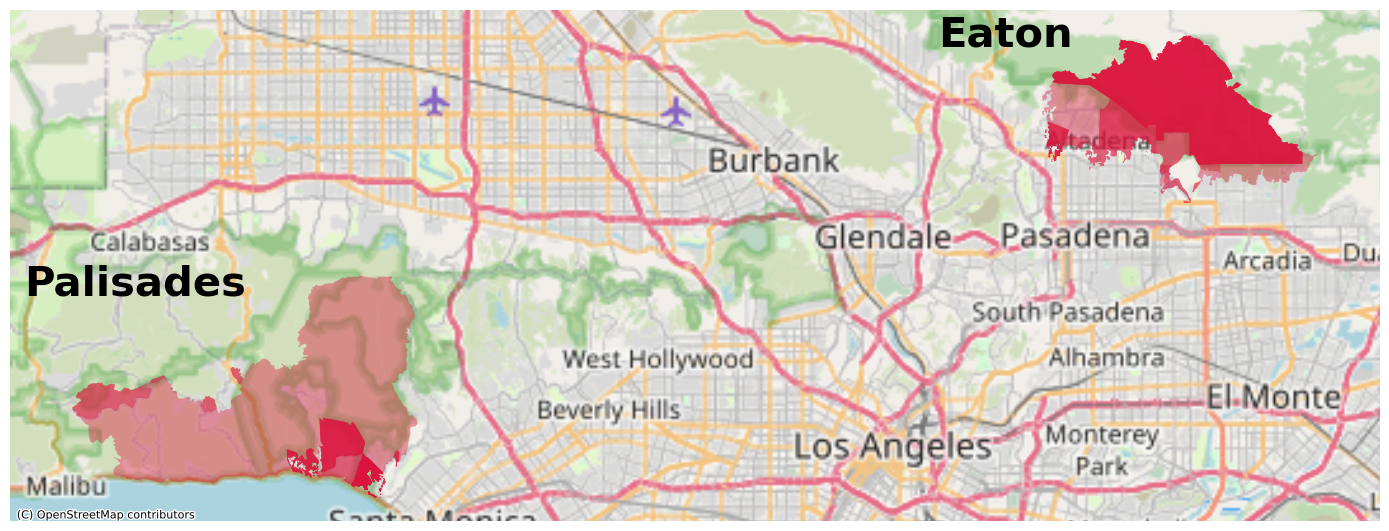

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR
palisades_clip.plot(ax=ax,
                   facecolor = 'crimson',
                   alpha = 0.4)

eaton_clip.plot(ax=ax,
               facecolor = 'crimson',
               alpha = 0.4)



# ADD BASEMAP USING CONTEXTILY
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


# ADD LEGEND OR ANNOTATION TO IDENTIFY EACH FIRE
ax.text(x=-13215000, y=4045000, s="Palisades", fontsize=30, color='black', weight='bold')
ax.text(x=-13160000, y=4060000, s="Eaton", fontsize=30, color='black', weight='bold')


# ADD TITLE

ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Visualize EJI data

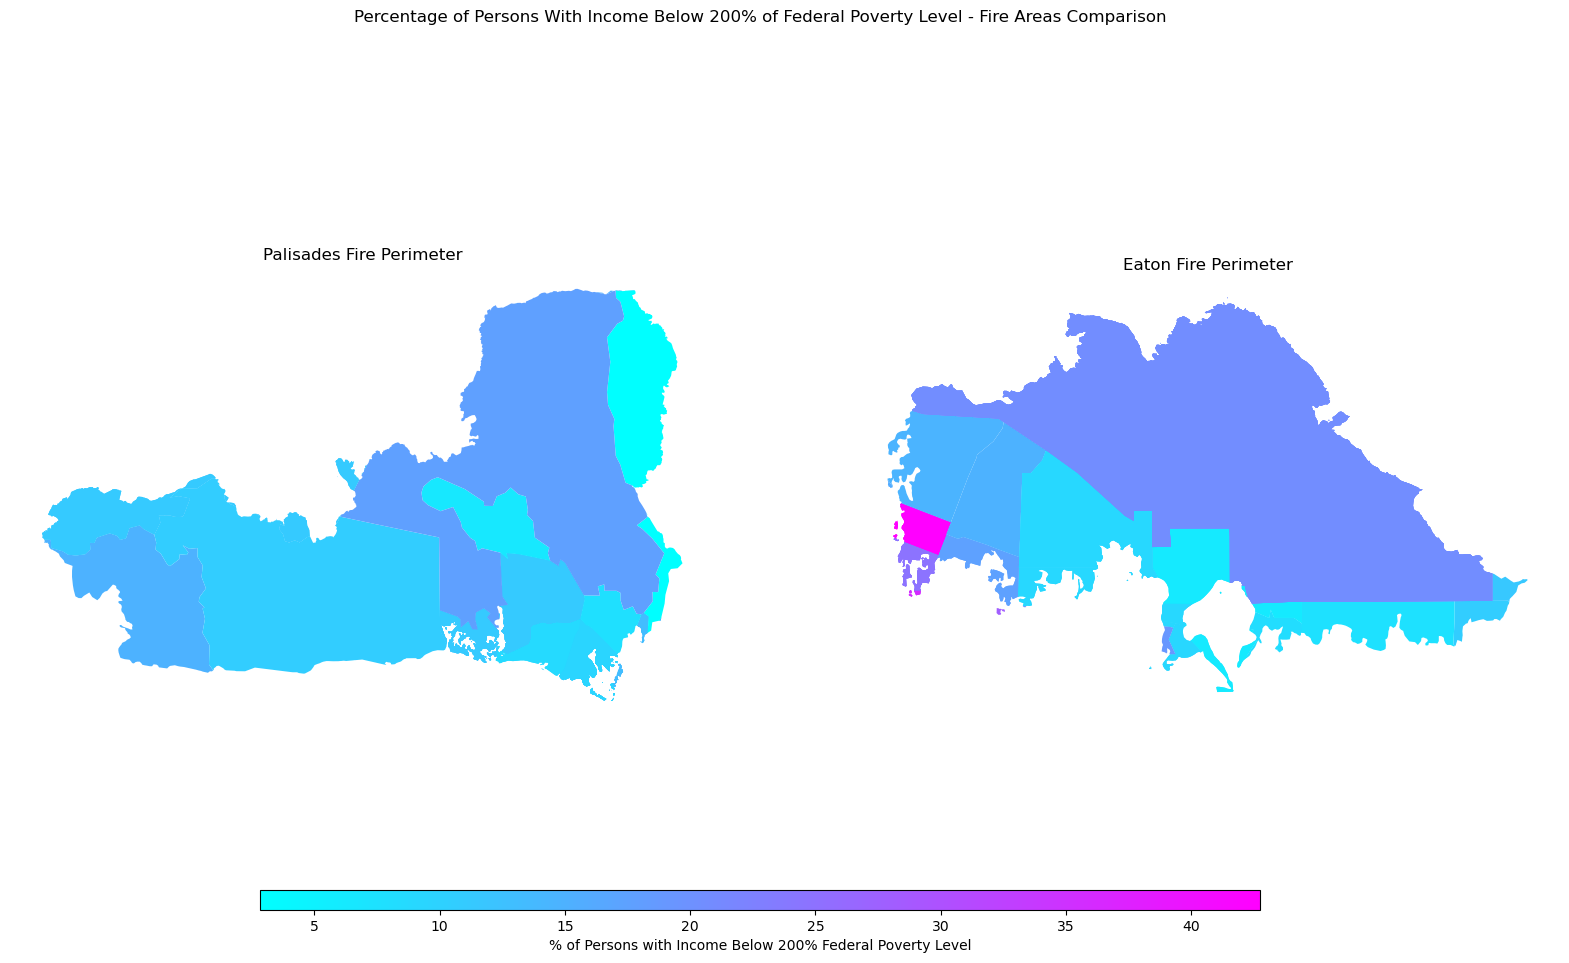

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'E_POV200' # Percentage of persons with income below 200% of the federal poverty level

# Find common min/max for legend range
vmin = min(palisades_clip[eji_variable].min(), eaton_clip[eji_variable].min())
vmax = max(palisades_clip[eji_variable].max(), eaton_clip[eji_variable].max())

# Plot census tracts within Palisades perimeter
palisades_clip.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    cmap = 'cool',
    ax=ax1,
)
ax1.set_title('Palisades Fire Perimeter')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eaton_clip.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    cmap = 'cool',
    ax=ax2,
)
ax2.set_title('Eaton Fire Perimeter')
ax2.axis('off')

# Add overall title
fig.suptitle('Percentage of Persons With Income Below 200% of Federal Poverty Level - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap ='cool')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('% of Persons with Income Below 200% Federal Poverty Level')
plt.show()